base spectral radius (before scaling) = 1.678684
rho=0.800 | exploded_run=False | lyapunov=-2.256081e-01 | final_norm=8.264e-63
rho=0.900 | exploded_run=False | lyapunov=-1.078251e-01 | final_norm=4.062e-32
rho=0.950 | exploded_run=False | lyapunov=-5.375786e-02 | final_norm=4.982e-18
rho=0.990 | exploded_run=False | lyapunov=-1.251490e-02 | final_norm=2.782e-07
rho=1.000 | exploded_run=False | lyapunov=-2.464563e-03 | final_norm=1.157e-04
rho=1.002 | exploded_run=False | lyapunov=-4.665606e-04 | final_norm=3.836e-04
rho=1.050 | exploded_run=False | lyapunov=2.922169e-02 | final_norm=1.977e+00
rho=1.100 | exploded_run=False | lyapunov=3.041189e-02 | final_norm=2.713e+00


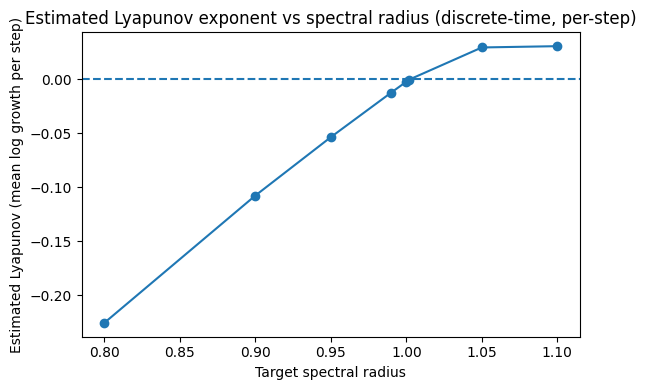

5


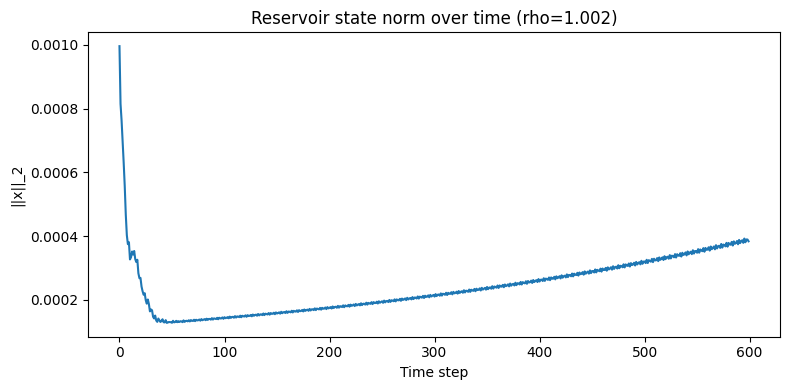

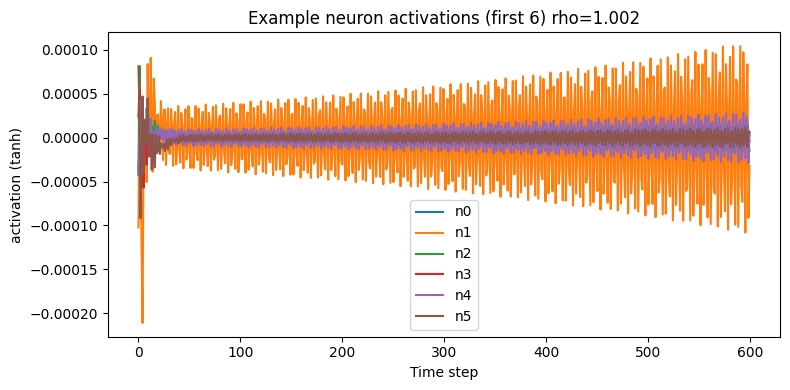

In [6]:
"""
Echo State Network (ESN) - edge-of-chaos exploration

What this does:
- Create a sparse reservoir W.
- Rescale W to target spectral radii near 1.0.
- Run autonomous dynamics x[t+1] = tanh(W x[t]) (no external input).
- Detect explosion if ||x|| grows past a large threshold.
- Estimate largest Lyapunov exponent by evolving two nearby trajectories.
- Plot Lyapunov vs spectral radius, reservoir norm over time, and a few neuron activations.

Dependencies:
    pip install numpy matplotlib
(Optional, faster spectral radius for large N):
    pip install scipy
"""

import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# Utilities
# ----------------------

def make_sparse_reservoir(N, density=0.02, scale=1.0, random_state=None):
    """
    Create a sparse reservoir matrix with Gaussian weights on a Bernoulli mask.
    - N: reservoir size
    - density: fraction of nonzero connections (0..1)
    - scale: multiply entire matrix by this factor (useful for initial scaling)
    - random_state: integer seed or None
    """
    rng = np.random.RandomState(random_state)
    mask = rng.rand(N, N) < density
    W = rng.randn(N, N) * mask
    # fix any all-zero rows for numerical stability
    row_sums = np.abs(W).sum(axis=1)
    zero_rows = np.where(row_sums == 0)[0]
    for r in zero_rows:
        j = rng.randint(0, N)
        W[r, j] = rng.randn()
    W *= scale
    return W

def spectral_radius_numpy(W):
    """Compute spectral radius (largest absolute eigenvalue) via numpy.linalg.eigvals.
    For large N, consider using scipy.sparse.linalg.eigs on a sparse matrix (not included here)."""
    vals = np.linalg.eigvals(W)
    return np.max(np.abs(vals))

def rescale_to_spectral_radius(W, target_rho):
    """Scale matrix W so its spectral radius == target_rho."""
    sr = spectral_radius_numpy(W)
    if sr == 0:
        return W
    return W * (target_rho / sr)

# ----------------------
# Dynamics, explosion check, Lyapunov estimate
# ----------------------

def run_autonomous(W, x0, steps=1000, explosion_threshold=1e6):
    """
    Run autonomous dynamics x <- tanh(W x).
    Returns:
      xs: array (T, N) of states (or until explosion)
      exploded: bool
    """
    N = W.shape[0]
    xs = np.zeros((steps, N))
    x = x0.copy()
    exploded = False
    for t in range(steps):
        x = np.tanh(W @ x)
        xs[t] = x
        norm = np.linalg.norm(x)
        if np.isnan(norm) or np.isinf(norm) or norm > explosion_threshold:
            exploded = True
            return xs[:t+1], True
    return xs, False

def estimate_lyapunov_two_trajectories(W, x0, perturb=1e-8, steps=500, renormalize_every=1):
    """
    Estimate largest Lyapunov exponent using two nearby trajectories (Benettin-style).
    - x and y start close (distance ~ perturb). Evolve both, measure distance growth.
    - optionally renormalize the difference every renormalize_every steps.
    Returns:
      lyap_estimate (per step discrete-time; >0 indicates exponential divergence),
      exploded (True if numerical explosion encountered)
    """
    N = W.shape[0]
    rng = np.random.RandomState(0)
    x = x0.copy()
    y = x0.copy() + rng.randn(N) * perturb
    d = np.linalg.norm(y - x)
    if d == 0:
        y += perturb * np.ones_like(x)
        d = np.linalg.norm(y - x)

    logs = []
    for t in range(steps):
        x = np.tanh(W @ x)
        y = np.tanh(W @ y)
        d_new = np.linalg.norm(y - x)
        if np.isnan(d_new) or np.isinf(d_new) or d_new > 1e12:
            return float('nan'), True
        # prevent div-by-zero:
        logs.append(np.log((d_new + 1e-16) / (d + 1e-16)))
        # renormalize to keep separation small and in linear regime
        if (t + 1) % renormalize_every == 0 and d_new != 0:
            y = x + (y - x) * (perturb / d_new)
            d = np.linalg.norm(y - x)
        else:
            d = d_new
    lyap = np.mean(logs)  # per-step discrete-time Lyapunov estimate
    return lyap, False

# ----------------------
# Example experiment: sweep a list of spectral radii around 1.0
# ----------------------

def experiment_and_plot(
        N=200,
        density=0.02,
        spectral_radii=None,
        sim_steps=800,
        lyap_steps=400,
        explosion_threshold=1e6,
        random_state=42):
    """
    Build one base random reservoir and for each target spectral radius:
      - scale reservoir
      - run autonomous dynamics
      - estimate Lyapunov
      - record explosion/decay and final norm
    Then plot lyapunov vs spectral radius and show time series for the radius closest to 1.
    """
    if spectral_radii is None:
        spectral_radii = np.array([0.8, 0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1])

    # Build base reservoir once (so only the scaling changes)
    base_W = make_sparse_reservoir(N, density=density, random_state=random_state)
    base_sr = spectral_radius_numpy(base_W)
    print(f"base spectral radius (before scaling) = {base_sr:.6f}")

    results = []
    for rho in spectral_radii:
        # Fast rescale: scale factor = rho / base_sr
        W = base_W * (rho / base_sr)
        x0 = np.random.RandomState(random_state + 1).randn(N) * 1e-4  # small random start
        xs, exploded = run_autonomous(W, x0, steps=sim_steps, explosion_threshold=explosion_threshold)
        lyap, lyap_exploded = estimate_lyapunov_two_trajectories(W, x0, perturb=1e-8, steps=lyap_steps)
        final_norm = np.linalg.norm(xs[-1])
        results.append({
            "rho": rho,
            "exploded_run": exploded,
            "lyapunov": lyap,
            "lyap_exploded": lyap_exploded,
            "final_norm": final_norm,
            "states": xs
        })
        print(f"rho={rho:.3f} | exploded_run={exploded} | lyapunov={lyap:.6e} | final_norm={final_norm:.3e}")

    # Plot Lyapunov vs rho
    rhos = np.array([r["rho"] for r in results])
    lyaps = np.array([r["lyapunov"] for r in results])
    plt.figure(figsize=(6,4))
    plt.plot(rhos, lyaps, marker='o')
    plt.axhline(0, linestyle='--')
    plt.title("Estimated Lyapunov exponent vs spectral radius (discrete-time, per-step)")
    plt.xlabel("Target spectral radius")
    plt.ylabel("Estimated Lyapunov (mean log growth per step)")
    plt.tight_layout()
    plt.show()

    # pick the rho closest to 1.0 for time-series plots
    idx_closest = np.argmin(np.abs(rhos - 1.0))
    idx_closest = 5
    print(idx_closest)
    chosen = results[idx_closest]
    xs_chosen = chosen["states"]
    T = xs_chosen.shape[0]
    times = np.arange(T)

    # Plot reservoir norm over time
    norms = np.linalg.norm(xs_chosen, axis=1)
    plt.figure(figsize=(8,4))
    plt.plot(times, norms)
    plt.title(f"Reservoir state norm over time (rho={chosen['rho']:.3f})")
    plt.xlabel("Time step")
    plt.ylabel("||x||_2")
    plt.tight_layout()
    plt.show()

    # Plot first few neuron activations
    num_neurons_plot = min(6, xs_chosen.shape[1])
    plt.figure(figsize=(8,4))
    for i in range(num_neurons_plot):
        plt.plot(times, xs_chosen[:, i], label=f"n{i}")
    plt.title(f"Example neuron activations (first {num_neurons_plot}) rho={chosen['rho']:.3f}")
    plt.xlabel("Time step")
    plt.ylabel("activation (tanh)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # return results dict for further analysis if wanted
    return results

# ----------------------
# If script is executed directly, run a demonstration experiment
# ----------------------
if __name__ == "__main__":
    # Example: smaller reservoir for quick experimentation
    results = experiment_and_plot(
        N=150,                # try larger N (200-1000) for more realistic reservoirs, but longer runtime
        density=0.02,         # sparse connectivity
        spectral_radii=np.array([0.8, 0.9, 0.95, 0.99, 1.0, 1.002, 1.05, 1.1]),
        sim_steps=600,
        lyap_steps=300,
        explosion_threshold=1e6,
        random_state=12345
    )


rho=0.800 | actual_sr=0.8000 | exploded_run=False | lyap=-2.255161e-01 | lyap_exploded=False | final_norm=1.007e-148
rho=0.900 | actual_sr=0.9000 | exploded_run=False | lyap=-1.064175e-01 | lyap_exploded=False | final_norm=9.599e-72
rho=0.950 | actual_sr=0.9500 | exploded_run=False | lyap=-5.294927e-02 | lyap_exploded=False | final_norm=3.081e-36
rho=0.990 | actual_sr=0.9900 | exploded_run=False | lyap=-1.179306e-02 | lyap_exploded=False | final_norm=1.378e-09
rho=1.000 | actual_sr=1.0000 | exploded_run=False | lyap=-1.954269e-03 | lyap_exploded=False | final_norm=7.278e-03
rho=1.010 | actual_sr=1.0100 | exploded_run=False | lyap=3.424784e-03 | lyap_exploded=False | final_norm=2.886e+00
rho=1.050 | actual_sr=1.0500 | exploded_run=False | lyap=4.088430e-03 | lyap_exploded=False | final_norm=6.561e+00
rho=1.100 | actual_sr=1.1000 | exploded_run=False | lyap=4.360121e-03 | lyap_exploded=False | final_norm=8.996e+00
rho=1.200 | actual_sr=1.2000 | exploded_run=False | lyap=1.564058e-02 | ly

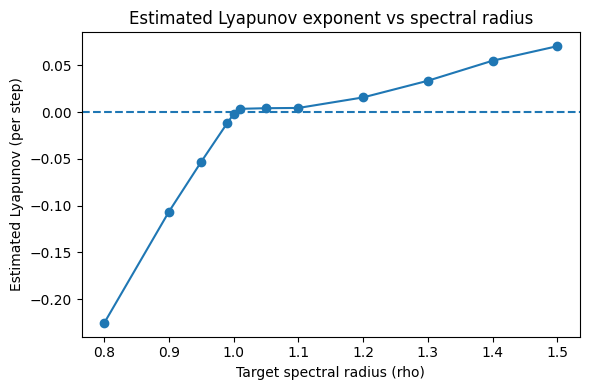

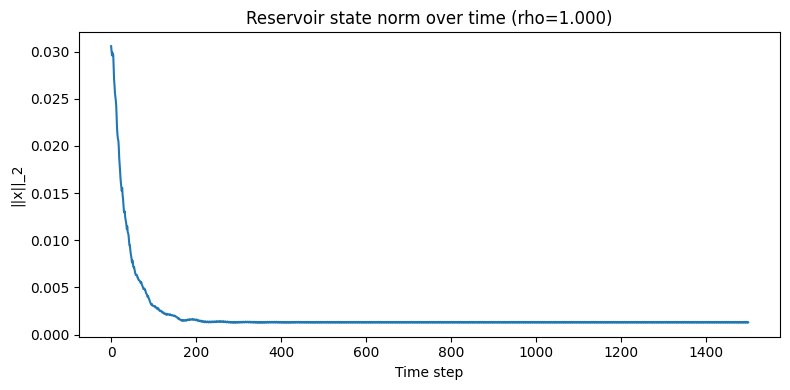

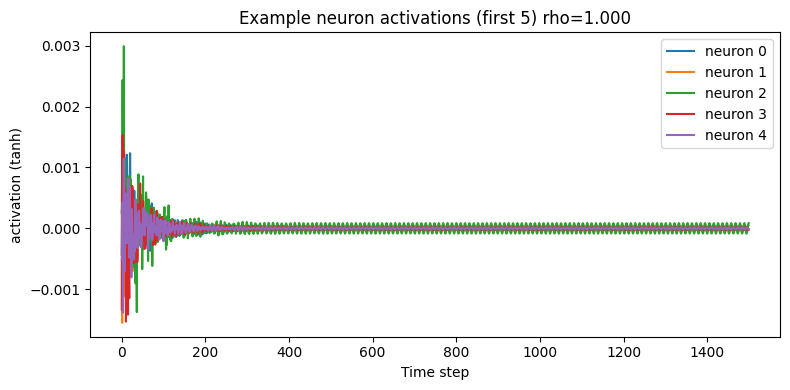


Summary of tested spectral radii:
rho=0.800 | actual_sr=0.8000 | exploded_run=False | lyapunov=-2.255161e-01 | final_norm=1.007e-148
rho=0.900 | actual_sr=0.9000 | exploded_run=False | lyapunov=-1.064175e-01 | final_norm=9.599e-72
rho=0.950 | actual_sr=0.9500 | exploded_run=False | lyapunov=-5.294927e-02 | final_norm=3.081e-36
rho=0.990 | actual_sr=0.9900 | exploded_run=False | lyapunov=-1.179306e-02 | final_norm=1.378e-09
rho=1.000 | actual_sr=1.0000 | exploded_run=False | lyapunov=-1.954269e-03 | final_norm=7.278e-03
rho=1.010 | actual_sr=1.0100 | exploded_run=False | lyapunov=3.424784e-03 | final_norm=2.886e+00
rho=1.050 | actual_sr=1.0500 | exploded_run=False | lyapunov=4.088430e-03 | final_norm=6.561e+00
rho=1.100 | actual_sr=1.1000 | exploded_run=False | lyapunov=4.360121e-03 | final_norm=8.996e+00
rho=1.200 | actual_sr=1.2000 | exploded_run=False | lyapunov=1.564058e-02 | final_norm=1.230e+01
rho=1.300 | actual_sr=1.3000 | exploded_run=False | lyapunov=3.346847e-02 | final_norm

In [3]:
# Creating and analyzing an Echo State Network (ESN) with a sparse reservoir.
# This code:
# - builds sparse random reservoirs
# - rescales them to target spectral radii (near 1)
# - runs autonomous dynamics (zero input) to observe whether states explode/decay
# - estimates the largest Lyapunov exponent via two nearby trajectories
# - plots results:
#    1) Lyapunov exponent vs spectral radius
#    2) Reservoir state norm over time (for radius closest to 1)
#    3) Example neuron activations over time (first 5 neurons) for that radius
#
# Notes on methods/parameters:
# - Reservoir update: x[t+1] = tanh(W @ x[t]) (no input, no leaking)
# - Lyapunov estimate: start two trajectories with small perturbation d0,
#   evolve them and compute mean local growth rate: lambda ≈ mean(log(d[t+1]/d[t]))
# - Explosion threshold: if any state norm exceeds 1e6 -> consider exploding
#
# Run-time parameters are moderate so this should execute quickly.
import numpy as np
import matplotlib.pyplot as plt
from math import log
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

np.random.seed(42)

def make_sparse_reservoir(N, density=0.01, scale=1.0):
    # Create sparse weight matrix: random normal weights where mask is True
    mask = np.random.rand(N, N) < density
    W = np.random.randn(N, N) * mask
    # ensure not all-zero row (helps with eigenvalue computation stability)
    row_sums = np.abs(W).sum(axis=1)
    zero_rows = np.where(row_sums == 0)[0]
    for r in zero_rows:
        j = np.random.randint(0, N)
        W[r, j] = np.random.randn()
    # scale overall
    W *= scale
    return W

def spectral_radius(W):
    # compute largest absolute eigenvalue
    vals = np.linalg.eigvals(W)
    return np.max(np.abs(vals))

def rescale_spectral_radius(W, target):
    # scale matrix so its spectral radius equals target
    sr = spectral_radius(W)
    if sr == 0:
        return W
    return W * (target / sr)

def run_esn_autonomous(W, x0, steps=1000, threshold=1e6):
    N = W.shape[0]
    xs = np.zeros((steps, N))
    x = x0.copy()
    exploded = False
    for t in range(steps):
        x = np.tanh(W @ x)
        xs[t] = x
        norm = np.linalg.norm(x)
        if np.isnan(norm) or np.isinf(norm):
            exploded = True
            break
        if norm > threshold:
            exploded = True
            break
    return xs[:t+1] if exploded else xs, exploded

def estimate_lyapunov(W, x0, perturb=1e-8, steps=1000, renormalize_every=1):
    # Two nearby trajectories method (Benettin-style but simplified)
    x = x0.copy()
    y = x0.copy() + (np.random.randn(*x0.shape) * perturb)
    d = np.linalg.norm(y - x)
    if d == 0:
        y += perturb
        d = np.linalg.norm(y - x)
    local_logs = []
    exploded = False
    for t in range(steps):
        x = np.tanh(W @ x)
        y = np.tanh(W @ y)
        d_new = np.linalg.norm(y - x)
        if np.isnan(d_new) or np.isinf(d_new) or d_new > 1e12:
            exploded = True
            break
        # avoid zero division
        if d > 0:
            local_logs.append(np.log(d_new / d + 1e-16))
        else:
            local_logs.append(np.log(d_new + 1e-16))
        # renormalize y to keep distance small and numerical stable
        if (t+1) % renormalize_every == 0 and d_new != 0:
            y = x + (y - x) * (perturb / d_new)
            d = np.linalg.norm(y - x)
        else:
            d = d_new
    if len(local_logs) == 0:
        return float('nan'), exploded
    # discrete-time Lyapunov per step estimate
    lyap = np.mean(local_logs)
    return lyap, exploded

# Parameters
N = 1000              # reservoir size
density = 0.02       # connectivity density (sparse)
steps = 1500         # time steps to simulate
washout = 100        # not used here, but could be used to discard transients
explosion_threshold = 1e6

# spectral radii to test (includes values around 1.0)
spectral_radii = np.array([0.8, 0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5])

results = []
base_W = make_sparse_reservoir(N, density=density, scale=1.0)  # base random mask and weights

for rho in spectral_radii:
    W = rescale_spectral_radius(base_W.copy(), rho)
    # initial small random state
    x0 = (np.random.randn(N) * 1e-3)
    # run autonomous ESN
    xs, exploded = run_esn_autonomous(W, x0, steps=steps, threshold=explosion_threshold)
    # estimate lyapunov using two nearby trajectories (use shorter run for lyap stability)
    lyap, lyap_exploded = estimate_lyapunov(W, x0, perturb=1e-8, steps=1000, renormalize_every=1)
    # store results
    results.append({
        "rho": rho,
        "spectral_radius_actual": spectral_radius(W),
        "exploded_run": exploded,
        "lyapunov": lyap,
        "lyap_exploded": lyap_exploded,
        "final_norm": np.linalg.norm(xs[-1])
    })
    print(f"rho={rho:.3f} | actual_sr={spectral_radius(W):.4f} | exploded_run={exploded} | lyap={lyap:.6e} | lyap_exploded={lyap_exploded} | final_norm={np.linalg.norm(xs[-1]):.3e}")

# Convert results to arrays for plotting
rhos = np.array([r["rho"] for r in results])
lyaps = np.array([r["lyapunov"] for r in results])
exploded_flags = np.array([r["exploded_run"] for r in results])

# Plot 1: Lyapunov exponent vs spectral radius
plt.figure(figsize=(6,4))
plt.plot(rhos, lyaps, marker='o')
plt.axhline(0, linestyle='--')
plt.title("Estimated Lyapunov exponent vs spectral radius")
plt.xlabel("Target spectral radius (rho)")
plt.ylabel("Estimated Lyapunov (per step)")
plt.tight_layout()
plt.show()

# Choose the radius closest to 1.0 for state-time plots
idx_closest = np.argmin(np.abs(rhos - 1.0))
chosen_rho = rhos[idx_closest]
W_chosen = rescale_spectral_radius(base_W.copy(), chosen_rho)
x0_chosen = (np.random.randn(N) * 1e-3)

xs_chosen, exploded_chosen = run_esn_autonomous(W_chosen, x0_chosen, steps=steps, threshold=explosion_threshold)
times = np.arange(xs_chosen.shape[0])

# Plot 2: Reservoir state norm over time
norms = np.linalg.norm(xs_chosen, axis=1)
plt.figure(figsize=(8,4))
plt.plot(times, norms)
plt.title(f"Reservoir state norm over time (rho={chosen_rho:.3f})")
plt.xlabel("Time step")
plt.ylabel("||x||_2")
plt.tight_layout()
plt.show()

# Plot 3: Example neuron activations (first 5 neurons) over time
plt.figure(figsize=(8,4))
for i in range(5):
    plt.plot(times, xs_chosen[:, i], label=f"neuron {i}")
plt.title(f"Example neuron activations (first 5) rho={chosen_rho:.3f}")
plt.xlabel("Time step")
plt.ylabel("activation (tanh)")
plt.legend()
plt.tight_layout()
plt.show()

# Print summarized table of results
print("\nSummary of tested spectral radii:")
for r in results:
    print(f"rho={r['rho']:.3f} | actual_sr={r['spectral_radius_actual']:.4f} | exploded_run={r['exploded_run']} | lyapunov={r['lyapunov']:.6e} | final_norm={r['final_norm']:.3e}")
